# Configuring the Feature Extraction Model
The use of the pre-trained VGG16 model provides some additional points of configuration.

The baseline model removed the top from the VGG model, including a global max pooling layer, which then feeds into an encoding of the features to a 128 element vector.

In this section, we will look at the following modifications to the baseline model:

* Using a global average pooling layer after the VGG model.
* Not using any global pooling.

In [9]:
from os import listdir
import numpy as np
import pandas as pd
import string
from nltk.translate.bleu_score import corpus_bleu
from pickle import load, dump
from IPython.display import Image
 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model, to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input 
from keras.models import Model
from keras.layers import Input, Dense, Flatten, LSTM
from keras.layers import RepeatVector, TimeDistributed
from keras.layers import Embedding
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalMaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D

import caption_generation_model_API as cgm
from caption_generation_model_API import *

In [2]:
path = 'D:/Program/dataset/Flickr8K/'

# load dev set
filename = path + 'Flickr8k_text/Flickr_8k.devImages.txt'
dataset = load_set(filename)
print('Dataset: {}'.format(len(dataset)))
# train-test split
train, test = train_test_split(dataset)
# descriptions
train_descriptions = load_clean_descriptions(path+'descriptions.txt', train)
test_descriptions = load_clean_descriptions(path+'descriptions.txt', test)
print('Descriptions: train={}, test={}'.format(len(train_descriptions), len(test_descriptions)))
# photo features
train_features = load_photo_features(path+'features.pkl', train)
test_features = load_photo_features(path+'features.pkl', test)
print('Photos: train={}, test={}'.format(len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: {}'.format(vocab_size))
# determine the maximum sequence length
max_length = max(len(s.split()) for s in list(train_descriptions.values()))
print('Description Length: {}'.format(max_length))

Dataset: 1000
Descriptions: train=100, test=100
Photos: train=100, test=100
Vocabulary Size: 366
Description Length: 25


In [4]:
verbose = 2
n_epochs = 50
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 1

In [5]:
def evaluate_and_print(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        actual.append([desc.split()])
        predicted.append(yhat.split())
        print('Actual:    {}'.format(desc))
        print('Predicted: {}'.format(yhat))
        print()
        if len(actual) >= 5:
            break
    # calculate BLEU score
    bleu = corpus_bleu(actual, predicted)
    return bleu

In [6]:
def run_experiment():
    # run experiment
    train_results, test_results = list(), list()
    for i in range(n_repeats):
        # define the model
        model = define_model(vocab_size, max_length)
        # fit model
        model.fit_generator(data_generator(train_descriptions, train_features, 
                                           tokenizer, max_length, n_photos_per_update), 
                            steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
        # evaluate model on training data
        train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
        test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
        # store
        train_results.append(train_score)
        test_results.append(test_score)
        print('>{}: train={} test={}'.format((i+1), train_score, test_score))
        
        return train_results, test_results

In [7]:
def save_res(train_results, test_results):
    # save results to file
    df = pd.DataFrame()
    df['train'] = train_results
    df['test'] = test_results
    print(df.describe())
    df.to_csv(path+model_name+'.csv', index=False)

## Global Average Pooling
We can replace the GlobalMaxPooling2D layer with a GlobalAveragePooling2D to achieve average pooling.

Global average pooling was developed to reduce overfitting for image classification problems, but may offer some benefit in interpreting the features extracted from the image.

For more on global average pooling, see the paper:

[Network In Network](https://arxiv.org/abs/1312.4400), 2013.

The updated `define_model()` function and experiment name are listed below.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 512)          0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 50)       18300       input_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (D

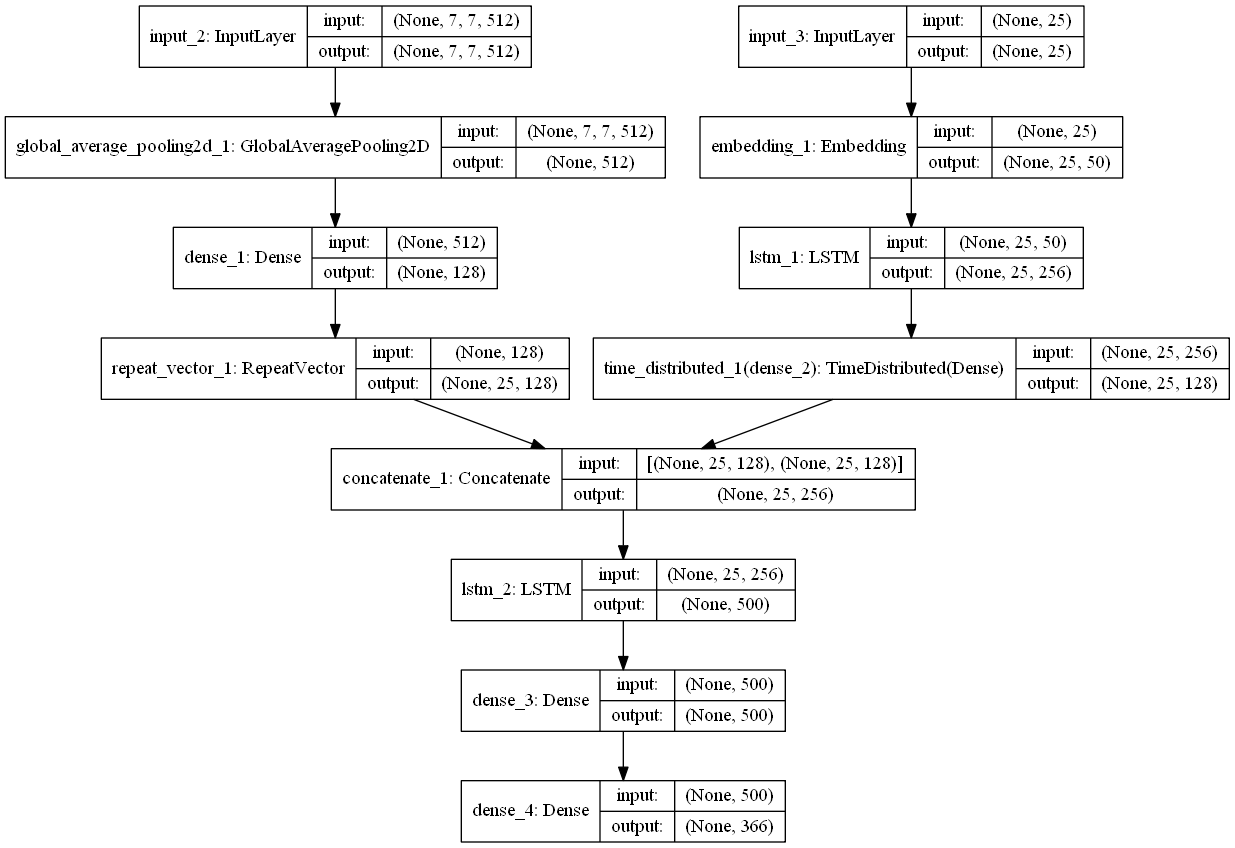

In [10]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalAveragePooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='fe_avg_pool_plot.png')
    
    return model
 
model_name = 'fe_avg_pool'
model = define_model(vocab_size, max_length)
Image('fe_avg_pool_plot.png')

In [11]:
train_results, test_results = run_experiment()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 512)          0           input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 25, 50)       18300       input_5[0][0]                    
__________________________________________________________________________________________________
dense_5 (D

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [12]:
save_res(train_results, test_results)

          train      test
count  1.000000  1.000000
mean   0.743892  0.077868
std         NaN       NaN
min    0.743892  0.077868
25%    0.743892  0.077868
50%    0.743892  0.077868
75%    0.743892  0.077868
max    0.743892  0.077868


In [13]:
trainset_score = evaluate_and_print(model, train_descriptions, train_features, tokenizer, max_length)
trainset_score

Actual:    startseq child and woman are at waters edge in big city endseq
Predicted: startseq slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide slide

Actual:    startseq boy with stick kneeling in front of goalie net endseq
Predicted: startseq night night night night night night night night night night night night night night night night night night night night night night night night night

Actual:    startseq woman crouches near three dogs in field endseq
Predicted: startseq girl girl girl girl girl girl girl girl motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle

Actual:    startseq boy bites hard into treat while he sits outside endseq
Predicted: startseq market market market market market market market market market market market market market market ma

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

In [14]:
testset_score = evaluate_and_print(model, test_descriptions, test_features, tokenizer, max_length)
testset_score

Actual:    startseq couple with young child wrapped in blanket sitting on concrete step endseq
Predicted: startseq slides slides slides runs face face face face face face face face face face face face face face face face face face face face face

Actual:    startseq adults and children stand and play in front of steps near wooded area endseq
Predicted: startseq overgrown coming coming coming coming coming coming overgrown overgrown overgrown overgrown overgrown overgrown overgrown overgrown overgrown overgrown overgrown overgrown overgrown overgrown overgrown overgrown overgrown overgrown

Actual:    startseq boy in grey pajamas is jumping on the couch endseq
Predicted: startseq bench bench tennis tennis above above above above above above above above above above above above above above above above above above above above above

Actual:    startseq boy holding kitchen utensils and making threatening face endseq
Predicted: startseq slide slide slide slide slide slide slide slide slide s

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

---
The results suggest a dramatic improvement on the training dataset, which may be a sign of overfitting.

We also see a small lift on test skill. This might be a change worth exploring.

## No Pooling
We can remove the GlobalMaxPooling2D and flatten the 3D photo feature and feed it directly into a Dense layer.

I would not expect this to be a good model design, but it is worth testing this assumption.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 25088)        0           input_6[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 25, 50)       18300       input_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (D

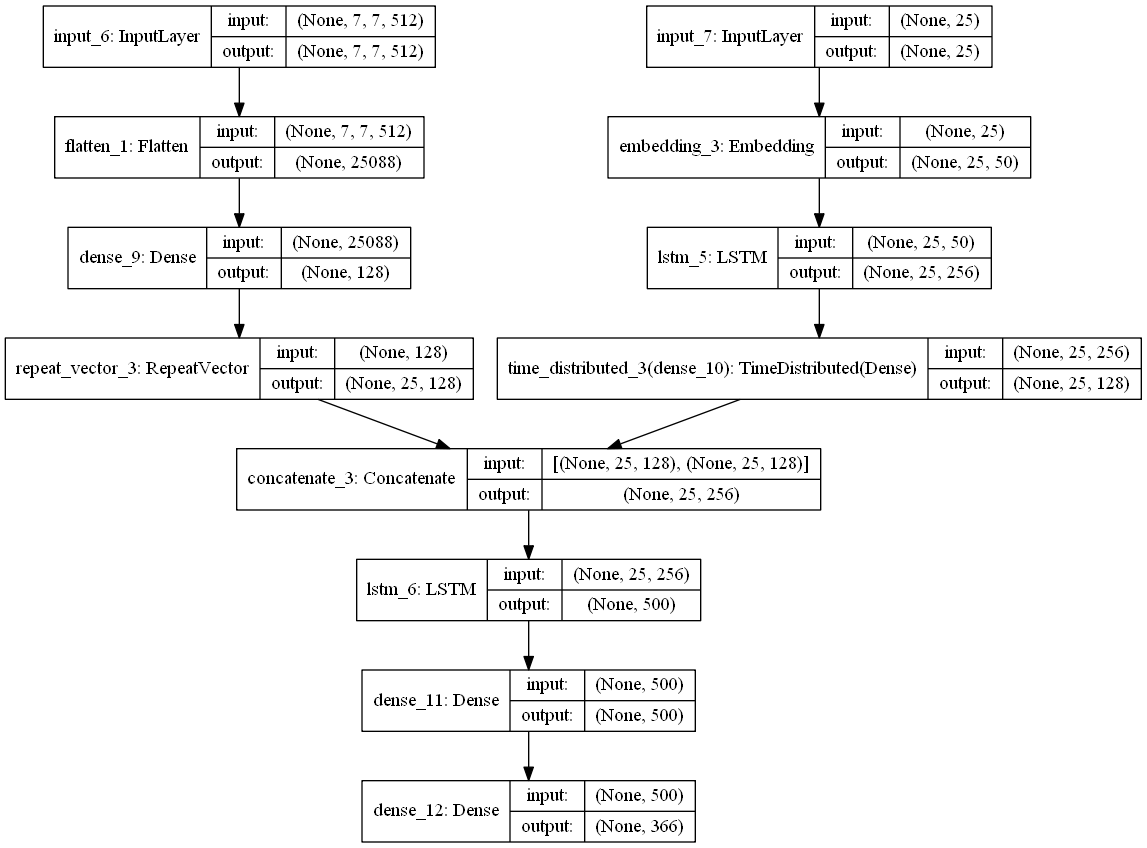

In [15]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = Flatten()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='fe_flat_plot.png')
    
    return model
 
model_name = 'fe_flat'
model = define_model(vocab_size, max_length)
Image('fe_flat_plot.png')

In [16]:
train_results, test_results = run_experiment()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 25088)        0           input_8[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 25, 50)       18300       input_9[0][0]                    
__________________________________________________________________________________________________
dense_13 (

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.062326550484077044 test=0.040280153558112104


In [17]:
save_res(train_results, test_results)

          train     test
count  1.000000  1.00000
mean   0.062327  0.04028
std         NaN      NaN
min    0.062327  0.04028
25%    0.062327  0.04028
50%    0.062327  0.04028
75%    0.062327  0.04028
max    0.062327  0.04028


In [18]:
trainset_score = evaluate_and_print(model, train_descriptions, train_features, tokenizer, max_length)
trainset_score

Actual:    startseq child and woman are at waters edge in big city endseq
Predicted: startseq before fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing fishing

Actual:    startseq boy with stick kneeling in front of goalie net endseq
Predicted: startseq before before before before before before before before before before before before before before before before before before before before before before before before before

Actual:    startseq woman crouches near three dogs in field endseq
Predicted: startseq blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue

Actual:    startseq boy bites hard into treat while he sits outside endseq
Predicted: startseq tennis tennis tennis tennis tennis tennis tennis tennis tennis tennis tennis tennis tennis tennis tennis tennis tennis tennis te

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

In [19]:
testset_score = evaluate_and_print(model, test_descriptions, test_features, tokenizer, max_length)
testset_score

Actual:    startseq couple with young child wrapped in blanket sitting on concrete step endseq
Predicted: startseq above brush brush brush brush brush brush brush brush brush brush brush brush brush brush brush brush brush brush brush brush brush brush brush brush

Actual:    startseq adults and children stand and play in front of steps near wooded area endseq
Predicted: startseq bike bike bike bike bike bike bike bike bike bike amplifier amplifier amplifier amplifier amplifier amplifier amplifier amplifier amplifier amplifier amplifier amplifier amplifier amplifier amplifier

Actual:    startseq boy in grey pajamas is jumping on the couch endseq
Predicted: startseq squirts looking get get get get children children children children children children children children children children children children children children children children children children children

Actual:    startseq boy holding kitchen utensils and making threatening face endseq
Predicted: startseq landscape landsca

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

---
Surprisingly, we see a small lift on training data and a large lift on test data.

# Word Embedding Models
A key part of the model is the sequence learning model that must interpret the sequence of words generated so far for a photo.

At the input to this sub-model is a word embedding and a good way to improve a word embedding over learning it from scratch as part of the model (as in the baseline model) is to use pre-trained word embeddings.

In this section, we will explore the impact of using a pre-trained word embedding on the model. Specifically:

* Training a Word2Vec Model
* Training a Word2Vec Model + Fine Tuning

## Trained word2vec Embedding
An efficient learning algorithm for pre-training a word embedding from a corpus of text is the word2vec algorithm.

You can learn more about the word2vec algorithm here:

* [Word2Vec Google Code Project](https://code.google.com/archive/p/word2vec/)

We can use this algorithm to train a new standalone set of word vectors using the cleaned photo descriptions in the dataset.

The [Gensim library](https://radimrehurek.com/gensim/models/word2vec.html) provides access to an implementation of the algorithm that we can use to pre-train the embedding.

First, we must load the clean photo descriptions for the training dataset, as before.

Next, we can fit the word2vec model on all of the clean descriptions. We should note that this includes more descriptions than the 50 used in the training dataset. A fairer model for these experiments should only be trained on those descriptions in the training dataset.

Once fit, we can save the words and word vectors to an ASCII file, perhaps for later inspection or visualization.

In [20]:
from gensim.models import Word2Vec

C:\Anaconda\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [21]:
# train word2vec model
lines = [s.split() for s in train_descriptions.values()]
model = Word2Vec(lines, size=100, window=5, workers=8, min_count=1)
# summarize vocabulary size in model
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))
 
# save model in ASCII (word2vec) format
filename = 'custom_embedding.txt'
model.wv.save_word2vec_format(filename, binary=False)

Vocabulary size: 365


The word embedding is saved to the file *‘custom_embedding.txt‘.*

Now, we can load the embedding into memory, retrieve only the word vectors for the words in our vocabulary, then save them to a new file.

In [27]:
# load the whole embedding into memory
embedding = dict()
file = open('custom_embedding.txt')
for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding[word] = coefs
file.close()
print('Embedding Size: %d' % len(embedding))
 
# summarize vocabulary
all_tokens = ' '.join(train_descriptions.values()).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: %d' % len(vocabulary))
 
# get the vectors for words in our vocab
cust_embedding = dict()
for word in vocabulary:
    # check if word in embedding
    if word not in embedding:
        continue
    cust_embedding[word] = embedding[word]
print('Custom Embedding %d' % len(cust_embedding))
 
# save
dump(cust_embedding, open('word2vec_embedding.pkl', 'wb'))
print('Saved Embedding')

Embedding Size: 366
Vocabulary Size: 365
Custom Embedding 365
Saved Embedding


---
Running this example creates a new dictionary mapping of word-to-word vectors stored in the file *‘word2vec_embedding.pkl‘.*

Next, we can load this embedding and use the word vectors as the fixed weights in an Embedding layer.

Below provides the `load_embedding()` function that loads the custom word2vec embedding and returns the new Embedding layer for use in the model.

In [31]:
# load a word embedding
def load_embedding(tokenizer, vocab_size, max_length):
    # load the tokenizer
    embedding = load(open('word2vec_embedding.pkl', 'rb'))
    dimensions = 100
    trainable = False
    # create a weight matrix for words in training docs
    weights = np.zeros((vocab_size, dimensions))
    # walk words in order of tokenizer vocab to ensure vectors are in the right index
    for word, i in tokenizer.word_index.items():
        if word not in embedding:
            continue
        weights[i] = embedding[word]
    layer = Embedding(vocab_size, dimensions, weights=[weights], 
                      input_length=max_length, trainable=trainable, mask_zero=True)
    return layer

In [33]:
plot_path = "C:/Ipython/Keras_practice/3.0-develop-a-caption-generation-model/plot/"

We can use it in our model by calling the function directly from our `define_model()` function.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_4 (GlobalM (None, 512)          0           input_16[0][0]                   
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 25, 100)      36600       input_17[0][0]                   
__________________________________________________________________________________________________
dense_26 (

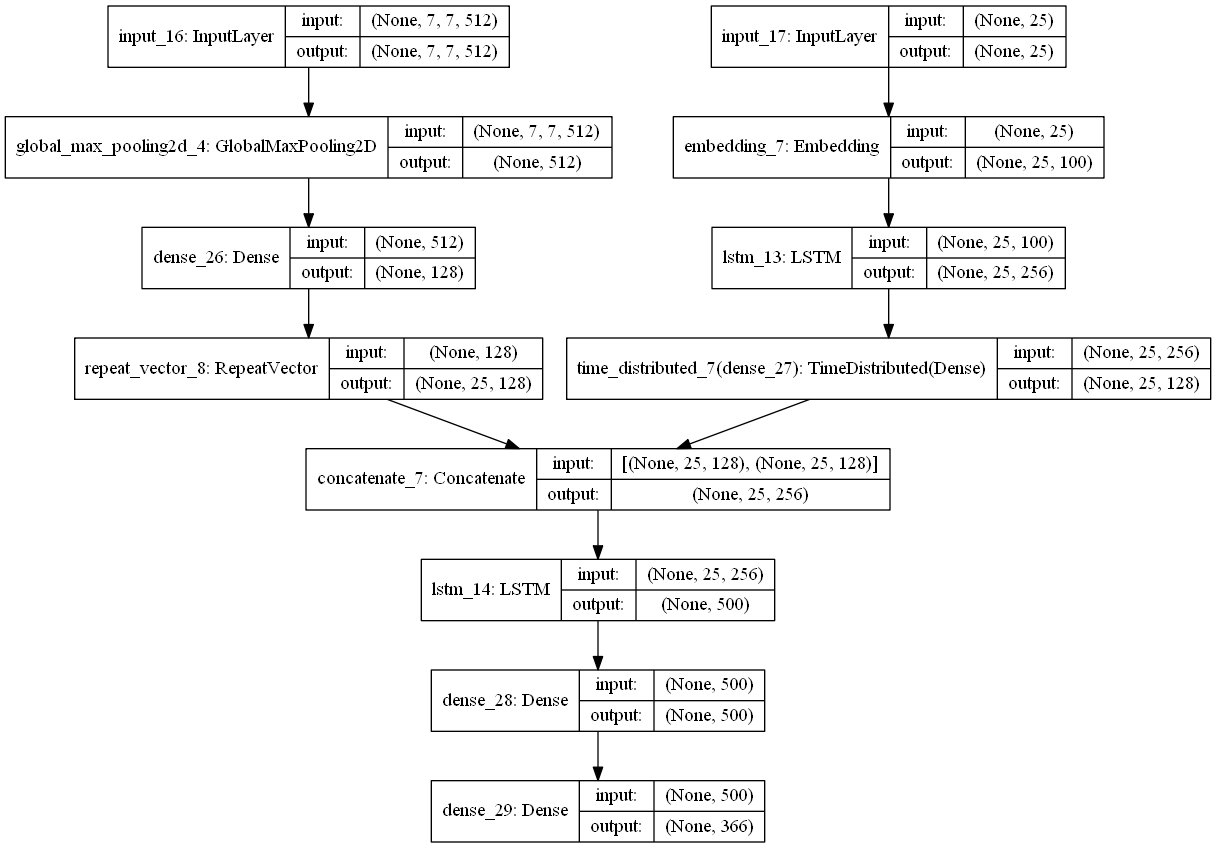

In [36]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = load_embedding(tokenizer, vocab_size, max_length)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file=plot_path+'seq_w2v_fixed_plot.png')
    
    return model
 
model_name = 'seq_w2v_fixed'
model = define_model(vocab_size, max_length)
Image(plot_path+'seq_w2v_fixed_plot.png')

In [37]:
train_results, test_results = run_experiment()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_5 (GlobalM (None, 512)          0           input_18[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 25, 100)      36600       input_19[0][0]                   
__________________________________________________________________________________________________
dense_30 (

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [38]:
save_res(train_results, test_results)

          train      test
count  1.000000  1.000000
mean   0.086531  0.042027
std         NaN       NaN
min    0.086531  0.042027
25%    0.086531  0.042027
50%    0.086531  0.042027
75%    0.086531  0.042027
max    0.086531  0.042027


In [39]:
trainset_score = evaluate_and_print(model, train_descriptions, train_features, tokenizer, max_length)
trainset_score

Actual:    startseq child and woman are at waters edge in big city endseq
Predicted: startseq front front front front front front front front front front front front front front front front front front front front front front front front front

Actual:    startseq boy with stick kneeling in front of goalie net endseq
Predicted: startseq bright bright bright bright bright bright bright bright bright bright bright bright bright bright bright bright bright bright bright bright bright bright bright bright bright

Actual:    startseq woman crouches near three dogs in field endseq
Predicted: startseq couch couch couch couch couch couch couch couch couch couch couch couch couch couch couch couch couch couch couch couch couch couch couch couch couch

Actual:    startseq boy bites hard into treat while he sits outside endseq
Predicted: startseq knocks knocks knocks knocks knocks knocks knocks knocks knocks knocks knocks knocks knocks knocks knocks knocks knocks knocks knocks knocks knocks knock

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

In [40]:
testset_score = evaluate_and_print(model, test_descriptions, test_features, tokenizer, max_length)
testset_score

Actual:    startseq couple with young child wrapped in blanket sitting on concrete step endseq
Predicted: startseq flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags

Actual:    startseq adults and children stand and play in front of steps near wooded area endseq
Predicted: startseq points with with with with with with with with with with with with with with with with with with with with with with with with

Actual:    startseq boy in grey pajamas is jumping on the couch endseq
Predicted: startseq kneeling kneeling kneeling flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags flags

Actual:    startseq boy holding kitchen utensils and making threatening face endseq
Predicted: startseq dinner dinner dinner dinner dinner dinner dinner dinner dinner dinner dinner dinner dinner dinner dinner dinner dinner dinner dinner d

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

---
We can see some lift on the training dataset, perhaps no real notable change on the test dataset.

## Trained word2vec Embedding with Fine Tuning
We can repeat the previous experiment and allow the model to tune the word vectors while fitting the model.

The updated `load_embedding()` function that permits the embedding layer to be fine-tuned is listed below.

In [41]:
# load a word embedding
def load_embedding(tokenizer, vocab_size, max_length):
    # load the tokenizer
    embedding = load(open('word2vec_embedding.pkl', 'rb'))
    dimensions = 100
    trainable = True
    # create a weight matrix for words in training docs
    weights = np.zeros((vocab_size, dimensions))
    # walk words in order of tokenizer vocab to ensure vectors are in the right index
    for word, i in tokenizer.word_index.items():
        if word not in embedding:
            continue
        weights[i] = embedding[word]
    layer = Embedding(vocab_size, dimensions, weights=[weights], 
                      input_length=max_length, trainable=trainable, mask_zero=True)
    return layer

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_6 (GlobalM (None, 512)          0           input_20[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 25, 100)      36600       input_21[0][0]                   
__________________________________________________________________________________________________
dense_34 (

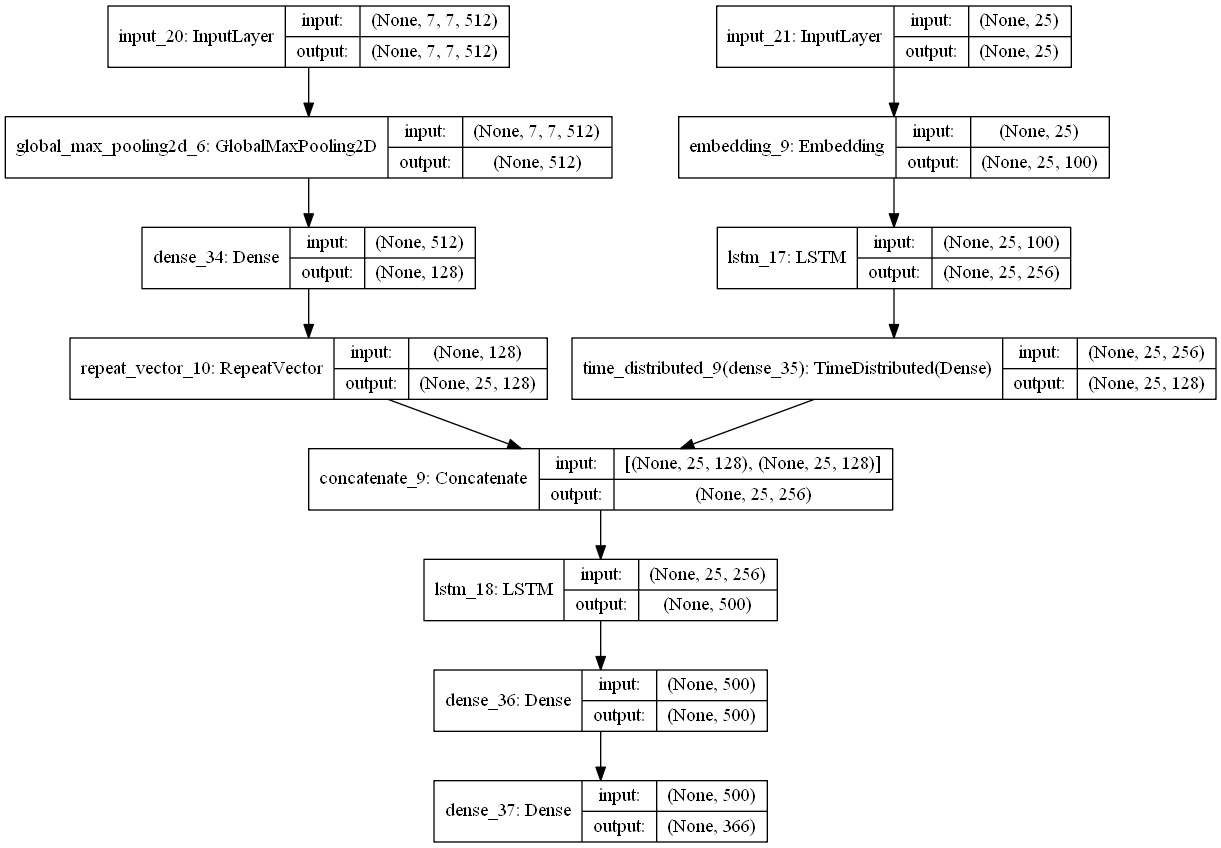

In [42]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = load_embedding(tokenizer, vocab_size, max_length)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file=plot_path+'seq_w2v_tuned_plot.png')
    
    return model
 
model_name = 'seq_w2v_tuned'
model = define_model(vocab_size, max_length)
Image(plot_path+'seq_w2v_tuned_plot.png')

In [43]:
train_results, test_results = run_experiment()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_7 (GlobalM (None, 512)          0           input_22[0][0]                   
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 25, 100)      36600       input_23[0][0]                   
__________________________________________________________________________________________________
dense_38 (

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.20282431296881556 test=0.02758435377422511


C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [44]:
save_res(train_results, test_results)

          train      test
count  1.000000  1.000000
mean   0.202824  0.027584
std         NaN       NaN
min    0.202824  0.027584
25%    0.202824  0.027584
50%    0.202824  0.027584
75%    0.202824  0.027584
max    0.202824  0.027584


In [45]:
trainset_score = evaluate_and_print(model, train_descriptions, train_features, tokenizer, max_length)
trainset_score

Actual:    startseq child and woman are at waters edge in big city endseq
Predicted: startseq frisbee wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing

Actual:    startseq boy with stick kneeling in front of goalie net endseq
Predicted: startseq third blue blue blue blue blue blue blue blue blue hangs hangs hangs hangs hangs hangs hangs hangs hangs hangs hangs hangs hangs hangs hangs

Actual:    startseq woman crouches near three dogs in field endseq
Predicted: startseq hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant hydrant

Actual:    startseq boy bites hard into treat while he sits outside endseq
Predicted: startseq very very very very very very very very very very very very very very very very very v

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

In [46]:
testset_score = evaluate_and_print(model, test_descriptions, test_features, tokenizer, max_length)
testset_score

Actual:    startseq couple with young child wrapped in blanket sitting on concrete step endseq
Predicted: startseq that bath bath bath bath bath bath bath bath bath bath bath bath bath bath bath bath bath bath bath bath bath bath bath bath

Actual:    startseq adults and children stand and play in front of steps near wooded area endseq
Predicted: startseq looking off racer racer racer racer racer racer racer racer traffic traffic traffic traffic traffic traffic traffic traffic traffic traffic traffic traffic traffic traffic traffic

Actual:    startseq boy in grey pajamas is jumping on the couch endseq
Predicted: startseq off off off off off off off off off off off off off off off off off off off off off off off off off

Actual:    startseq boy holding kitchen utensils and making threatening face endseq
Predicted: startseq are that that that that that that that that that that that that that that that that that that that that that that that that

Actual:    startseq man in green hat is 

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

---
Again, we do not see much difference in using these pre-trained word embedding vectors over the baseline model.

# Analysis of Results

We have performed a few experiments on a very small sample (1.6%) from the Flickr8k training dataset of 8,000 photos.

It is possible that the sample is too small, that the models were not trained for long enough, and that 3 repeats of each model results in too much variance. These aspects can also be tested by evaluated by designing experiments such as:

1. Does model skill scale with the size of the dataset?
2. Do more epochs result in better skill?
3. Do more repeats result in a skill with less variance?

Nevertheless, we have some ideas on how we might configure a model for the fuller dataset.

Below is a summary of the mean results from the experiments performed in this tutorial.

It is helpful to review a graph of the results. If we had more repeats, a box and whisker plot for each distribution of scores might be a good visualization. Here we use a simple bar graph. Remember, that larger BLEU scores are better.

In [49]:
from os import listdir
from pandas import read_csv
from pandas import DataFrame
from matplotlib import pyplot

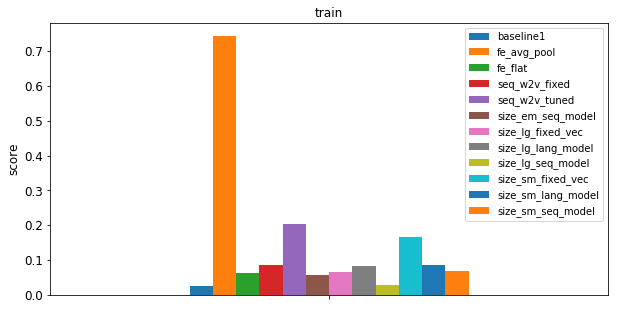

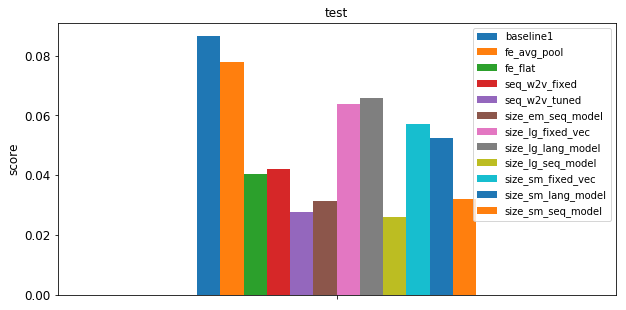

In [72]:
train, test = DataFrame(), DataFrame()
directory = 'D:/Program/dataset/Flickr8K/result_csv'
for name in listdir(directory):
    if not name.endswith('csv'):
        continue
    filename = directory + '/' + name
    data = read_csv(filename, header=0)
    experiment = name.split('.')[0]
    train[experiment] = data['train']
    test[experiment] = data['test']
    
train = train.drop([1,2])  
test = test.drop([1,2])

ax = train.plot(kind='bar', title ="train", figsize=(10, 5), legend=True, fontsize=12)
ax.set_ylabel("score", fontsize=12)
ax.axes.xaxis.set_ticklabels([])
pyplot.show()

ax = test.plot(kind='bar', title ="test", figsize=(10, 5), legend=True, fontsize=12)
ax.set_ylabel("score", fontsize=12)
ax.axes.xaxis.set_ticklabels([])
pyplot.show()

From just looking at the mean results on the test dataset, we can suggest:

* Perhaps pooling is not required after the photo feature extractor (fe_flat at 0.135231).
* Perhaps average pooling offers an advantage over max pooling after the photo feature extractor (fe_avg_pool at 0.060847).
* Perhaps a smaller sized fixed-length vector after the sub-models is a good idea (size_sm_fixed_vec at 0.063148).
* Perhaps adding more layers to the language model offers some benefit (size_lg_lang_model at 0.067658).
* Perhaps adding more layers to the sequence model offers some benefit (size_lg_seq_model at 0.09697).

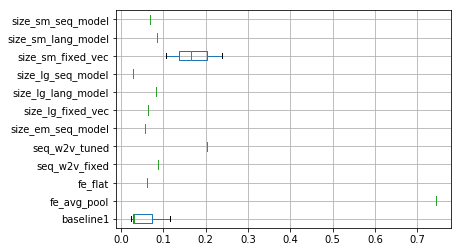

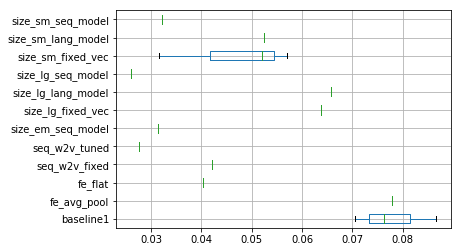

In [73]:
# load all .csv results into a dataframe
train, test = DataFrame(), DataFrame()
directory = 'D:/Program/dataset/Flickr8K/result_csv'
for name in listdir(directory):
    if not name.endswith('csv'):
        continue
    filename = directory + '/' + name
    data = read_csv(filename, header=0)
    experiment = name.split('.')[0]
    train[experiment] = data['train']
    test[experiment] = data['test']

# plot results on train
train.boxplot(vert=False)
pyplot.show()
# plot results on test
test.boxplot(vert=False)
pyplot.show()

A review of these distributions suggests:

* The spread on the flat results is large; perhaps going with average pooling might be safer.
* The spread on the larger language model is large and skewed in the wrong/risky direction.
* The spread on the larger sequence model is large and skewed in the right direction.
* There may be some benefit in a smaller fixed-length vector size.
I would expect increasing repeats to 5, 10, or 30 would tighten up these distributions somewhat.

# Summary

* How to prepare data for photo captioning modeling.
* How to design a baseline and test harness to evaluate the skill of models and control for their stochastic nature.
* How to evaluate properties like model skill, feature extraction model, and word embeddings in order to lift model skill.

# Dataset copyright

Please cite M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results

## Reference

https://machinelearningmastery.com/develop-a-caption-generation-model-in-keras/